## Загрузим нужные библиотеки

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

from sklearn.metrics import recall_score, precision_score

from shapely.geometry import shape

In [101]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Рассмотрим датасет по ближе

In [5]:
df = pd.read_csv("train_dataset_train.csv")
y_train = df[["crop"]].values.ravel()
df = df.drop(["crop"], axis = 1)

test_df = pd.read_csv("./test_dataset_test.csv")

# преобразование датасета

In [6]:
def centroid_fe(df): 
    df['geo_dict'] = df['.geo'].apply(lambda x: json.loads(x))
    df = df.drop([".geo"], axis = 1)

    df['x'] = df['geo_dict'].apply(lambda x: shape(x).centroid.x)
    df['y'] = df['geo_dict'].apply(lambda x: shape(x).centroid.y)

    return df.drop(["id","geo_dict"], axis = 1)

In [7]:
def cluster_fe(df, mode): 
    if mode == "train":
        df['cluster'] = model.fit_predict(df[['x','y']].values)
    else:
        df['cluster'] = model.predict(df[['x','y']].values)
    
#     df['rot_45_x'] = (0.707 * df['x']) + (0.707 * df['y'])
#     df['rot_45_y'] = (0.707 * df['y']) + (0.707 * df['x'])
#     df['rot_30_x'] = (0.866 * df['x']) + (0.5 * df['y'])
#     df['rot_30_y'] = (0.866 * df['y']) + (0.5 * df['x'])

    return df

In [8]:
from sklearn.neighbors import KDTree

def neighbors_fe(df, mode, k, y_train):    
        
    distances, indices = kd.query(df[["x", "y"]], k = k + (mode == "train"))
    
    if mode == "train":
        distances = distances[:, 1:]
        indices = indices[:, 1:]
        
    for i in range(k):
        df[f'{i}_distance'] = distances[:,i]
  
    return df

In [9]:
def xy_rad_fe(df): 
    df[f'x_rad'] = np.deg2rad(df['x'].values)
    df[f'y_rad'] = np.deg2rad(df['y'].values)
    return df

In [10]:
# from sklearn.neighbors import BallTree

# def neighbors_ball_fe(df, mode, k):    
#     if mode == "train": k+=1
        
#     distances, indices = ball.query(df[["x_rad", "y_rad"]], k = k)
    
#     if mode == "train":
#         distances = distances[:, 1:]
#         indices = indices[:, 1:]
        
#     if mode == "train": k-=1
#     for i in range(k):
#         df[f'{i}_haversine_distance'] = distances[:,i]
  
#     return df

In [11]:
# ball = BallTree(X_train[["x_rad", "x_rad"]].values, metric='haversine')

# X_train = neighbors_ball_fe(X_train, 'train', 5)
# X_test  = neighbors_ball_fe(X_test, 'test', 5)

# X_test.tail(3)

In [12]:
# import reverse_geocoder as rg
# def geocoder(data):
#     '''
#     input: dataframe containing Latitude(x) and Longitude(y) coordinates
#     output: JSON data containing info on available building or street names.
#     '''
#     coordinates = data[['x','y']].values
#     results = rg.search(coordinates.tolist()) # default mode = 2
#     return results
# geocoder(fe(df))

In [13]:
# from sklearn.cluster import KMeans
# model = KMeans(n_clusters=100)

# X_train = cluster_fe(X_train, 'train')
# X_test  = cluster_fe(X_test, 'test')

# Train

In [14]:
X_train= centroid_fe(df)
X_test = centroid_fe(test_df)

X_test.tail(3)

,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,nd_mean_2021-05-16,...,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,x,y
2068,92,0.131978,0.058492,0.607262,0.389112,0.061173,0.185756,0.000000,0.545505,0.260217,...,0.000000,0.000000,0.055619,0.051682,0.008488,0.076760,0.038590,0.086436,37.903507,53.138644
2069,53,0.044726,0.093328,0.188758,0.290000,0.178694,0.286592,0.041403,0.241813,0.499471,...,0.000000,0.053296,0.200393,0.000000,0.040434,0.037837,0.000000,0.165996,38.991007,51.862706
2070,33,0.000000,0.003819,0.149500,0.077181,0.161075,0.220894,0.125081,0.042906,0.157184,...,0.146481,0.098958,0.137899,0.120050,0.051349,0.000000,0.010335,0.143800,37.676814,53.791727


In [15]:
X_train= xy_rad_fe(X_train)
X_test = xy_rad_fe(X_test)

X_test.tail(3)

,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,nd_mean_2021-05-16,...,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,x,y,x_rad,y_rad
2068,92,0.131978,0.058492,0.607262,0.389112,0.061173,0.185756,0.000000,0.545505,0.260217,...,0.055619,0.051682,0.008488,0.076760,0.038590,0.086436,37.903507,53.138644,0.661541,0.927444
2069,53,0.044726,0.093328,0.188758,0.290000,0.178694,0.286592,0.041403,0.241813,0.499471,...,0.200393,0.000000,0.040434,0.037837,0.000000,0.165996,38.991007,51.862706,0.680521,0.905175
2070,33,0.000000,0.003819,0.149500,0.077181,0.161075,0.220894,0.125081,0.042906,0.157184,...,0.137899,0.120050,0.051349,0.000000,0.010335,0.143800,37.676814,53.791727,0.657584,0.938843


In [12]:
kd = KDTree(X_train[["x", "y"]].values, metric='euclidean')

X_train = neighbors_fe(X_train, 'train', 5, y_train)
X_test  = neighbors_fe(X_test, 'test', 5, y_train)
X_test.tail(3)

In [18]:
model = lightgbm.LGBMClassifier(learning_rate=0.3)
scores = cross_val_score(model, X_train, y_train)
np.mean(scores)

SCORE: 0.9691568098550818
SCORE: 0.9726012941267417
SCORE: 0.9767629919916802
SCORE: 0.9765503447365075
SCORE: 0.9739495647004144


0.973804201082085

In [19]:
# model = lightgbm.LGBMClassifier(learning_rate=0.3)
# scores = cross_val_score(model, X_train, y_train)
# np.mean(scores)

In [20]:
# 

# Stacking

In [126]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot


# get a stacking ensemble of models
def get_stacking():
    
    # define the base models
    level0 = list()
    
    level0.append(
        ('lr', Pipeline([('scaler', StandardScaler()),
                         ('lr', LogisticRegression())])
        ))
    
    level0.append(
        ('knn', Pipeline([('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier())])
        ))
    
    level0.append(
        ('svm', Pipeline([('scaler', StandardScaler()),
                         ('svm', SVC())])
        ))
    
#     level0.append(('knn', KNeighborsClassifier()))
#     level0.append(('cart', DecisionTreeClassifier()))
#     level0.append(('svm', SVC()))
#     level0.append(('bayes', GaussianNB()))

#     level0.append(('xgb', XGBClassifier(eval_metric='mlogloss', )))
#     level0.append(('catboost', CatBoostClassifier(, verbose=False)))
#     level0.append(('cat_gpu', CatBoostClassifier(, verbose=False, task_type='GPU')))

    level0.append(('lgbm', lightgbm.LGBMClassifier(learning_rate=0.3)))
    
    # define meta learner model
    level1 = LogisticRegression()
    
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model


# get a list of models to evaluate
def get_models():
    models = dict()
    
    models['lr'] = Pipeline([('scaler', StandardScaler()),
                             ('lr', LogisticRegression())])
        
    models['knn'] = Pipeline([('scaler', StandardScaler()),
                              ('knn', KNeighborsClassifier())])
  
    models['cart'] = DecisionTreeClassifier()
        
    models['svm'] = Pipeline([('scaler', StandardScaler()),
                              ('svm', SVC())])
        
    models['bayes'] = GaussianNB()


#     models['xgb'] = XGBClassifier(eval_metric='mlogloss', )
#     models['cat_gpu'] = CatBoostClassifier(, verbose=False, task_type='GPU')  
#     models['catboost'] = CatBoostClassifier(, verbose=False)    
        
    models['lgbm'] = lightgbm.LGBMClassifier(learning_rate=0.3, )
    
    models['stacking'] = get_stacking()
    
    return models


# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y)
    return scores

In [127]:
# # define dataset
# X, y = get_dataset()

In [128]:
def train(models):
    # evaluate the models and store results
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X_train, y_train)
        results.append(scores)
        names.append(name)
        print(f"\n{name:8} {mean(scores):.5f} ({std(scores):.5f})")

    # plot model performance for comparison
    pyplot.boxplot(results, labels=names, showmeans=True)
    pyplot.show()

In [129]:
# get the models to evaluate
models = get_models()

0.96349  0.9689  0.9632 0.95563 0.94996 0.91914 0.96998 0.93914 0.96403 0.98188 0.94539 0.96377 0.95782 0.95212 0.96374  0.9513 0.93398 0.95132 0.94535 0.95699 0.95104 0.95647 0.93344 0.96918 0.95305 0.96968 0.94556 0.95147 0.98212 0.93879 lr       0.95493 (0.01385)
0.90267 0.90862 0.86561 0.87157 0.89455 0.84583 0.91509 0.85884 0.88354 0.90161 0.88427 0.89752 0.88785 0.92184 0.89072 0.87157 0.87801 0.83505 0.89667 0.90777 0.89533 0.88288 0.88319 0.88834  0.8849 0.89046 0.86687 0.88569 0.89732 0.91556 knn      0.88699 (0.01941)
0.91267 0.92645 0.94563 0.91184 0.89401 0.90648  0.8902 0.93132 0.92725   0.927 0.91996 0.90243 0.89563 0.92591 0.88476 0.90613 0.90208 0.90074 0.92615 0.90481 0.95076 0.87046 0.90128 0.90751 0.92762 0.92273 0.91435 0.86064 0.89559 0.89242 cart     0.90949 (0.01975)
0.91267 0.92645 0.94563 0.91184 0.89401 0.90648  0.8902 0.93132 0.92725   0.927 0.91996 0.90243 0.89563 0.92591 0.88476 0.90613 0.90208 0.90074 0.92615 0.90481 0.95076 0.87046 0.90128 0.90751 0.92762

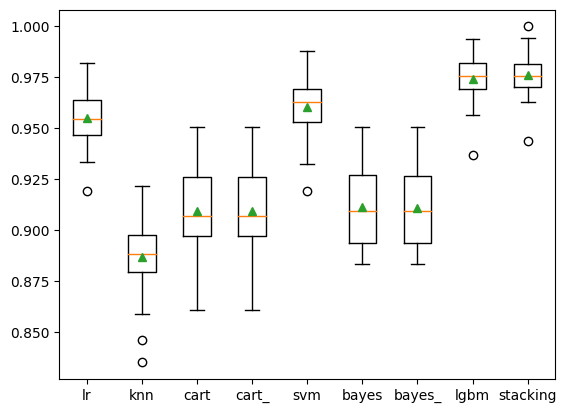

In [130]:
train(models)

0.96972 0.98755  0.9816 0.96266 0.95673 0.93104 0.97619 0.95753 0.98163 0.98784 0.95782 0.97567 0.96351 0.97593  0.9697 0.95076  0.9697 0.97511 0.95699 0.97513 0.96861 0.95645 0.96349 0.98188 0.98236 0.96476 0.97613 0.97017 0.99351 0.95201 xgb      0.96907 (0.01307)
 0.9697 0.98755  0.9697 0.95671 0.96269 0.93132 0.98214 0.95104 0.99405 0.98188 0.97593 0.96972 0.96972 0.98188 0.97024  0.9697 0.94535 0.96916 0.95104 0.97485 0.96861  0.9505  0.9697 0.96946 0.98807 0.97071 0.96396 0.96344 0.99429 0.97017 cat_gpu  0.96911 (0.01389)
0.96349 0.98755 0.96916 0.96266 0.96918 0.93699 0.97619 0.96998 0.98784 0.98784 0.96403 0.97567 0.97593 0.96972 0.98214  0.9816 0.95779 0.98106  0.9697 0.97485 0.98134 0.95645  0.9816 0.98784 0.99379 0.97071 0.98238  0.9813 0.99351 0.95851 lgbm     0.97436 (0.01235)
0.97539 0.98755 0.97565 0.96266 0.96918 0.93754 0.98214 0.96403     1.0 0.98188 0.96998 0.97567 0.98188 0.97593 0.97619  0.9697 0.95184 0.98106 0.96944 0.97459 0.96861 0.96294 0.96374 0.98163 0.98807

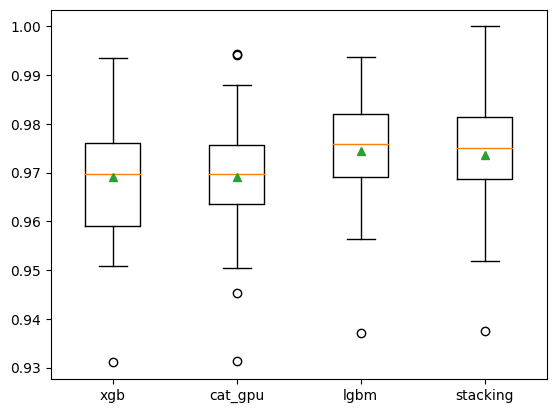

In [111]:
train(models)

In [ ]:
# mapper = DataFrameMapper(
#   [([cat_column], [CategoricalDomain(), OneHotEncoder()]) for cat_column in cat_columns] +
#   [([cont_column], [ContinuousDomain(), StandardScaler()]) for cont_column in cont_columns]
# )


# Neural Net

In [20]:
from functools import partial
from collections import defaultdict

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader

In [22]:
seed = 1
np.random.seed(seed)

In [23]:
def create_datasets(df, target, test_df, valid_pct=0.2, seed=None):
    """Converts NumPy arrays into PyTorch datsets.
    
    Three datasets are created in total:
        * training dataset
        * validation dataset
        * testing (un-labelled) dataset

    """
    sz = df.shape[0]
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(idx, test_size=valid_pct, random_state=seed)
    
    trn_ds = TensorDataset(
        torch.tensor(df[:sz][trn_idx]).float(), 
        torch.tensor(target[:sz][trn_idx]).long())
    
    val_ds = TensorDataset(
        torch.tensor(df[:sz][val_idx]).float(), 
        torch.tensor(target[:sz][val_idx]).long())
    
    tst_ds = TensorDataset(
        torch.tensor(test_df).float(),
    )
    
    return trn_ds, val_ds, tst_ds

In [24]:
def create_loaders(data, bs=128, jobs=8):
    """Wraps the datasets returned by create_datasets function with data loaders."""
    
    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl

In [25]:
# class _SepConv1d(nn.Module):
#     """A simple separable convolution implementation.
    
#     The separable convlution is a method to reduce number of the parameters 
#     in the deep learning network for slight decrease in predictions quality.
#     """
#     def __init__(self, ni, no, kernel, stride, pad):
#         super().__init__()
#         self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
#         self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

#     def forward(self, x):
#         return self.pointwise(self.depthwise(x))
    
    
# class SepConv1d(nn.Module):
#     """Implementes a 1-d convolution with 'batteries included'.
    
#     The module adds (optionally) activation function and dropout layers right after
#     a separable convolution layer.
#     """
#     def __init__(self, ni, no, kernel, stride, pad, drop=None,
#                  activ=lambda: nn.ReLU(inplace=True)):
    
#         super().__init__()
#         assert drop is None or (0.0 < drop < 1.0)
#         layers = [_SepConv1d(ni, no, kernel, stride, pad)]
#         if activ:
#             layers.append(activ())
#         if drop is not None:
#             layers.append(nn.Dropout(drop))
#         self.layers = nn.Sequential(*layers)
        
#     def forward(self, x): 
#         return self.layers(x)

In [26]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [27]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, no, drop=.4):
        super().__init__()
        
        self.raw = nn.Sequential(
            nn.Conv1d(1, 32, 8, 2, 3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32),
            nn.Dropout(drop),
            
            nn.Conv1d(32, 64, 8, 4, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.Dropout(drop),
            
            nn.Conv1d(64, 128, 8, 4, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            
#             nn.Conv1d(128, 256, 8, 2, 2),
#             nn.ReLU(inplace=True),
            
            
#             SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
#             SepConv1d(    32,  64, 8, 4, 2, drop=drop),
#             SepConv1d(    64, 128, 8, 4, 2, drop=drop),
#             SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 128), nn.ReLU(inplace=True), nn.BatchNorm1d(128),
#             nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True)
        )
        
    
        self.out = nn.Sequential(
            nn.Dropout(drop), nn.Linear(128, 64), nn.ReLU(inplace=True), nn.BatchNorm1d(64),
            nn.Linear(64, no))
        
    def forward(self, t_raw):
        t_raw = t_raw.unsqueeze(dim=1)
        raw_out = self.raw(t_raw)
#         t_in = torch.cat([raw_out, fft_out], dim=1)
        out = self.out(raw_out)
        return out

In [28]:
time_series_columm = []
for col in X_test.columns.values:
    if "nd_mean" in col:
        time_series_columm.append(col)
time_series_columm.sort()

In [29]:
X_train.shape

(4830, 115)

In [30]:
datasets = create_datasets(X_train[time_series_columm].values, 
                           y_train, 
                           X_test[time_series_columm].values, 
                           seed=seed)

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
raw_feat = X_train[time_series_columm].values.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

lr = 0.001
n_epochs = 3000
iterations_per_epoch = len(trn_dl)
num_classes = 7
best_acc = 0
best_rec = 0
patience, trials = 500, 0
base = 1
step = 2
loss_history = []
acc_history = []

model = Classifier(raw_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_raw)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= len(trn_dl)
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    rec = []
    for batch in val_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
        
        rec.append(recall_score(y_batch.cpu(), preds.cpu(), average="macro", zero_division=0))
    
    acc = correct / total
    acc_history.append(acc)
    rec = np.array(rec).mean()

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%} Rec.: {rec:2.2%}')
        base *= step

    if rec > best_rec:
        trials = 0
        best_rec = rec
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {acc:2.2%} best_Rec.: {best_rec:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 399.5719. Acc.: 31.78% Rec.: 33.07%
Epoch 1 best model saved with accuracy: 31.78% best_Rec.: 33.07%
Epoch:   2. Loss: 237.2908. Acc.: 57.76% Rec.: 61.56%
Epoch 2 best model saved with accuracy: 57.76% best_Rec.: 61.56%
Epoch 3 best model saved with accuracy: 75.78% best_Rec.: 77.64%
Epoch:   4. Loss: 135.8285. Acc.: 85.09% Rec.: 85.80%
Epoch 4 best model saved with accuracy: 85.09% best_Rec.: 85.80%
Epoch 5 best model saved with accuracy: 88.72% best_Rec.: 89.38%
Epoch 6 best model saved with accuracy: 89.86% best_Rec.: 90.45%
Epoch 7 best model saved with accuracy: 91.72% best_Rec.: 92.15%
Epoch:   8. Loss: 78.9636. Acc.: 90.68% Rec.: 91.25%
Epoch 9 best model saved with accuracy: 92.86% best_Rec.: 93.27%
Epoch 11 best model saved with accuracy: 93.06% best_Rec.: 93.41%
Epoch 13 best model saved with accuracy: 93.37% best_Rec.: 93.72%
Epoch:  16. Loss: 53.0670. Acc.: 93.27% Rec.: 93.63%
Epoch 17 best model saved with accuracy: 93.37% best_Rec.: 

In [32]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [5]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

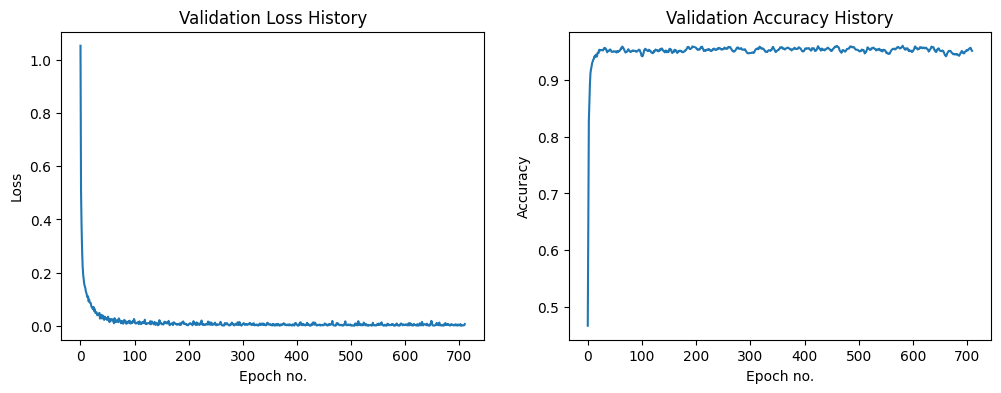

In [451]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

In [33]:
def cosine(epoch, t_max, ampl):
    """Shifted and scaled cosine function."""
    
    t = epoch % t_max
    return (1 + np.cos(np.pi*t/t_max))*ampl/2

In [34]:
def inv_cosine(epoch, t_max, ampl):
    """A cosine function reflected on X-axis."""
    
    return 1 - cosine(epoch, t_max, ampl)

In [35]:
def one_cycle(epoch, t_max, a1=0.6, a2=1.0, pivot=0.3):
    """A combined schedule with two cosine half-waves."""
    
    pct = epoch / t_max
    if pct < pivot:
        return inv_cosine(epoch, pivot*t_max, a1)
    return cosine(epoch - pivot*t_max, (1-pivot)*t_max, a2)

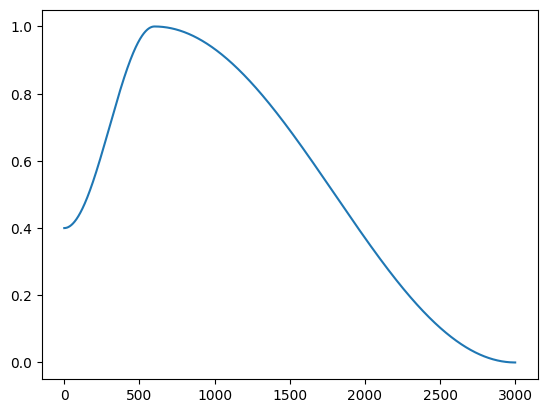

In [36]:
n = 3000
sched = partial(one_cycle, t_max=n, pivot=0.2)
items = [sched(t) for t in range(n)]
plt.plot(items);

In [37]:
class Scheduler:
    """Updates optimizer's learning rates using provided scheduling function."""
    
    def __init__(self, opt, schedule):
        self.opt = opt
        self.schedule = schedule
        self.history = defaultdict(list)
    
    def step(self, t):
        for i, group in enumerate(self.opt.param_groups):
            lr = opt.defaults['lr'] * self.schedule(t)
            group['lr'] = lr
            self.history[i].append(lr)

In [39]:
raw_feat = X_train[time_series_columm].values.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

lr = 0.001
n_epochs = 3000
iterations_per_epoch = len(trn_dl)
period = n_epochs*iterations_per_epoch
num_classes = 7
best_acc = 0
best_rec = 0
patience, trials = 1500, 0
base = 1
step = 2
iteration = 0
loss_history = []
acc_history = []

model = Classifier(raw_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)

# one-cycle learning rate scheduling
sched = Scheduler(opt, partial(one_cycle, t_max=period, pivot=0.3))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
        sched.step(iteration)  # update the learning rate
        opt.zero_grad()
        out = model(x_raw)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= len(trn_dl)
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    rec = []
    for batch in val_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
        
        rec.append(recall_score(y_batch.cpu(), preds.cpu(), average="macro", zero_division=0))
    
    acc = correct / total
    acc_history.append(acc)
    rec = np.array(rec).mean()

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%} Rec.: {rec:2.2%}')
        base *= step

    if rec > best_rec:
        trials = 0
        best_rec = rec
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {acc:2.2%} best_Rec.: {best_rec:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 446.4410. Acc.: 23.60% Rec.: 27.75%
Epoch 1 best model saved with accuracy: 23.60% best_Rec.: 27.75%
Epoch:   2. Loss: 342.3636. Acc.: 40.48% Rec.: 45.75%
Epoch 2 best model saved with accuracy: 40.48% best_Rec.: 45.75%
Epoch 3 best model saved with accuracy: 65.53% best_Rec.: 69.00%
Epoch:   4. Loss: 227.3288. Acc.: 76.29% Rec.: 77.58%
Epoch 4 best model saved with accuracy: 76.29% best_Rec.: 77.58%
Epoch 5 best model saved with accuracy: 79.92% best_Rec.: 81.08%
Epoch 6 best model saved with accuracy: 83.23% best_Rec.: 84.41%
Epoch 7 best model saved with accuracy: 84.89% best_Rec.: 85.79%
Epoch:   8. Loss: 136.6905. Acc.: 86.34% Rec.: 87.17%
Epoch 8 best model saved with accuracy: 86.34% best_Rec.: 87.17%
Epoch 9 best model saved with accuracy: 86.85% best_Rec.: 87.74%
Epoch 10 best model saved with accuracy: 88.20% best_Rec.: 88.84%
Epoch 11 best model saved with accuracy: 88.51% best_Rec.: 89.03%
Epoch 12 best model saved with accuracy: 88.61

In [50]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, no, drop=.4):
        super().__init__()
        
        self.raw = nn.Sequential(
            nn.Conv1d(1, 32, 8, 2, 3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32),
            nn.Dropout(drop),
            
            nn.Conv1d(32, 64, 8, 2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.Dropout(drop),
            
            nn.Conv1d(64, 128, 8, 2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            
            nn.Conv1d(128, 256, 8, 2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            
#             nn.Conv1d(256, 512, 8, 2, 2),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(512),
            
#             nn.Conv1d(128, 256, 8, 2, 2),
#             nn.ReLU(inplace=True),
            
            
#             SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
#             SepConv1d(    32,  64, 8, 4, 2, drop=drop),
#             SepConv1d(    64, 128, 8, 4, 2, drop=drop),
#             SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(512, 128), nn.ReLU(inplace=True), nn.BatchNorm1d(128),
#             nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True)
        )
        
    
        self.out = nn.Sequential(
            nn.Dropout(drop), nn.Linear(128, 64), nn.ReLU(inplace=True), nn.BatchNorm1d(64),
            nn.Linear(64, no))
        
    def forward(self, t_raw):
        t_raw = t_raw.unsqueeze(dim=1)
        raw_out = self.raw(t_raw)
#         t_in = torch.cat([raw_out, fft_out], dim=1)

        out = self.out(raw_out)
        return out

In [ ]:
raw_feat = X_train[time_series_columm].values.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

lr = 0.001
n_epochs = 3000
iterations_per_epoch = len(trn_dl)
period = n_epochs*iterations_per_epoch
num_classes = 7
best_acc = 0
best_rec = 0
patience, trials = 1500, 0
base = 1
step = 2
iteration = 0
loss_history = []
acc_history = []

model = Classifier(raw_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)

# one-cycle learning rate scheduling
sched = Scheduler(opt, partial(one_cycle, t_max=period, pivot=0.3))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
        sched.step(iteration)  # update the learning rate
        opt.zero_grad()
        out = model(x_raw)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= len(trn_dl)
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    rec = []
    for batch in val_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
        
        rec.append(recall_score(y_batch.cpu(), preds.cpu(), average="macro", zero_division=0))
    
    acc = correct / total
    acc_history.append(acc)
    rec = np.array(rec).mean()

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%} Rec.: {rec:2.2%}')
        base *= step

    if rec > best_rec:
        trials = 0
        best_rec = rec
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {acc:2.2%} best_Rec.: {best_rec:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 412.0187. Acc.: 23.81% Rec.: 28.03%
Epoch 1 best model saved with accuracy: 23.81% best_Rec.: 28.03%
Epoch:   2. Loss: 280.6876. Acc.: 53.42% Rec.: 57.00%
Epoch 2 best model saved with accuracy: 53.42% best_Rec.: 57.00%
Epoch 3 best model saved with accuracy: 76.60% best_Rec.: 77.52%
Epoch:   4. Loss: 173.0189. Acc.: 82.82% Rec.: 83.25%
Epoch 4 best model saved with accuracy: 82.82% best_Rec.: 83.25%
Epoch 5 best model saved with accuracy: 85.30% best_Rec.: 85.69%
Epoch 6 best model saved with accuracy: 87.78% best_Rec.: 88.32%
Epoch 7 best model saved with accuracy: 88.10% best_Rec.: 88.74%
Epoch:   8. Loss: 98.7738. Acc.: 89.03% Rec.: 89.47%
Epoch 8 best model saved with accuracy: 89.03% best_Rec.: 89.47%
Epoch 10 best model saved with accuracy: 89.96% best_Rec.: 90.48%
Epoch 11 best model saved with accuracy: 90.06% best_Rec.: 90.57%
Epoch 12 best model saved with accuracy: 91.10% best_Rec.: 91.62%
Epoch 13 best model saved with accuracy: 91.20

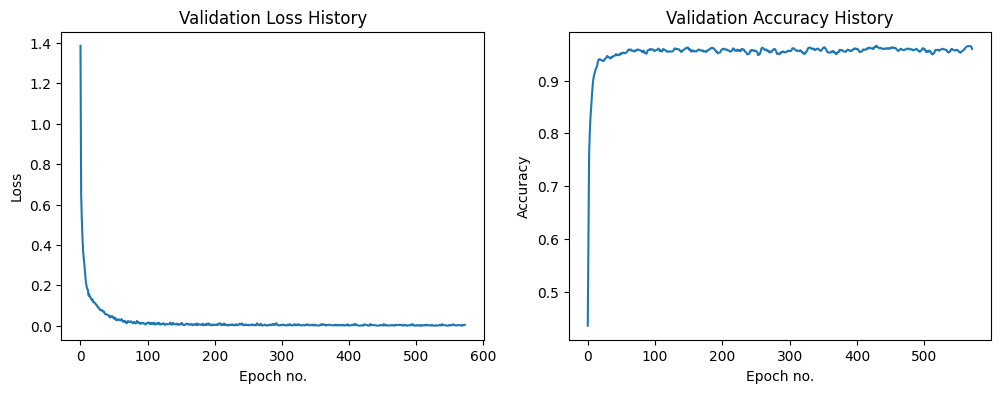

In [464]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

In [488]:
test_results = []
model.load_state_dict(torch.load('best.pth'))
model.eval()
for x_raw in tst_dl:
    batches = [t.to(device) for t in (x_raw)]
    out = model(*batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test_results.extend(y_hat.tolist())

In [489]:
test_results

[3,
 2,
 3,
 1,
 6,
 3,
 6,
 4,
 1,
 3,
 3,
 0,
 0,
 4,
 2,
 2,
 6,
 6,
 4,
 6,
 2,
 0,
 3,
 3,
 5,
 6,
 3,
 5,
 4,
 1,
 4,
 4,
 6,
 3,
 4,
 2,
 0,
 3,
 3,
 5,
 4,
 6,
 6,
 2,
 0,
 0,
 0,
 6,
 2,
 5,
 3,
 4,
 3,
 1,
 1,
 4,
 5,
 1,
 3,
 6,
 3,
 4,
 0,
 0,
 1,
 0,
 0,
 0,
 5,
 5,
 4,
 4,
 4,
 3,
 3,
 2,
 0,
 2,
 4,
 4,
 4,
 6,
 3,
 1,
 2,
 3,
 4,
 1,
 5,
 6,
 5,
 4,
 0,
 1,
 5,
 5,
 5,
 2,
 5,
 6,
 3,
 6,
 3,
 3,
 2,
 6,
 4,
 3,
 3,
 5,
 1,
 4,
 4,
 6,
 2,
 3,
 4,
 1,
 0,
 1,
 3,
 5,
 3,
 6,
 2,
 4,
 3,
 0,
 0,
 6,
 0,
 2,
 0,
 0,
 4,
 3,
 1,
 0,
 1,
 1,
 4,
 2,
 5,
 2,
 3,
 6,
 2,
 2,
 1,
 6,
 5,
 1,
 3,
 6,
 6,
 2,
 1,
 6,
 6,
 5,
 2,
 2,
 2,
 4,
 5,
 6,
 0,
 4,
 5,
 0,
 1,
 6,
 0,
 1,
 5,
 5,
 4,
 2,
 0,
 6,
 3,
 6,
 1,
 1,
 6,
 0,
 0,
 2,
 2,
 5,
 1,
 1,
 3,
 3,
 5,
 4,
 4,
 4,
 5,
 3,
 3,
 3,
 1,
 4,
 3,
 6,
 6,
 6,
 4,
 1,
 6,
 3,
 1,
 5,
 6,
 3,
 2,
 5,
 0,
 5,
 6,
 3,
 4,
 4,
 2,
 1,
 4,
 5,
 5,
 0,
 2,
 1,
 4,
 2,
 2,
 2,
 0,
 0,
 3,
 3,
 6,
 1,
 3,
 6,
 1,
 5,
 5,
 5,
 6,
 1,


### Optuna

In [1]:
# from catboost import CatBoostClassifier
# column_transformer = ColumnTransformer([
#     ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
#     ('scaling', MinMaxScaler(), numeric_features)
# ])

# rfc_pipeline = Pipeline(steps=[
#     ('ohe_n_scaling_n_map', column_transformer),
#     ('classifier', xgb.XGBClassifier())
# ])

# model = rfc_pipeline.fit(X_train, y_train)

# pred = model.predict(X_test)
# print(model['classifier'],'\n',recall_score(y_test, pred, average="macro", zero_division=0))

In [2]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'num_iterations': [300, 1000],
# #     'learning_rate':[0.1, 0.05, 0.005 ],
# #     'num_leaves':[-1, 7, 15, 31  ],
# #     'max_depth' :[ 10,15,25],
# #     'min_data_in_leaf':[15,25 ],
# #     'feature_fraction': [ 0.6, 0.8,  0.9],
# #     'bagging_fraction': [  0.6, 0.8 ],
# #     'bagging_freq': [   100, 200, 400  ],
     
#     }
# param_grid_ = {}
# for key in param_grid:
#     param_grid_["classifier__" + key] = param_grid[key]

# searcher = GridSearchCV(rfc_pipeline, 
#                         param_grid=param_grid_,
#                         cv=5, 
#                         n_jobs=-1,
#                         verbose=3)

# searcher.fit(X_train, y_train)

In [20]:
# def objective(trial, data=X_train, target=y_train):

#     params = {
#         "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1),
# #         "n_estimators": trial.suggest_int('n_estimators', 100, 3000),
#         'tree_method': 'gpu_hist'
#     }
    
#     model = XGBClassifier(eval_metric='mlogloss', **params)  
#     scores = cross_val_score(model, X_train, y_train)

#     return np.mean(scores)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)

# print('Best value: ', study.best_value)
# print('Best best_params: ', study.best_params)

In [6]:
def objective(trial, data=X_train, target=y_train):
    params = {
#         "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1),
        "learning_rate": trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4]),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'device': 'cpu'
    }
    
    model = LGBMClassifier(**params)  
    scores = cross_val_score(model, X_train, y_train)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Best value: ', study.best_value)
print('Best best_params: ', study.best_params)

In [ ]:
def objective(trial, data=X_train, target=y_train):
    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1),
#         "n_estimators": trial.suggest_int('n_estimators', 100, 3000),
        'task_type': 'GPU'
    }
    
    model = CatBoostClassifier(verbose=False, **params)  
    scores = cross_val_score(model, X_train, y_train)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Best value: ', study.best_value)
print('Best best_params: ', study.best_params)

## FeatureSelector

In [ ]:
X_transform = column_transformer.fit_transform(X)

feature_names = X_train.columns

In [ ]:
#import libraries
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

#Fit the model
clf = LassoCV().fit(X_transform, y)

#Selected features
importance = np.abs(clf.coef_)
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()[:10]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

In [ ]:
#import libraries
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
#Fit the model
svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X_transform, y)
#Selected features
print(X.columns[rfecv.get_support()])
print("Optimal number of features : %d" % rfecv.n_features_)

In [ ]:
#import libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
#Fit the model
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_transform, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concatenate the two dataframes
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
#print 10 best features
print(featureScores.nlargest(10,'Score').plot(kind='barh'))
#plot graph of feature importances 
plt.show()



In [ ]:
# #Name selected features
X.iloc[:,61].name,X.iloc[:,51].name,X.iloc[:,66].name,X.iloc[:,63].name,X.iloc[:,18].name

In [ ]:
#import libraries
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
#Fit the model
model = ExtraTreesClassifier()
model.fit(X_transform, y)
print(model.feature_importances_)
#plot graph of feature importances
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
columns_after_selection = ['x', 'y', 'nd_mean_2021-06-16', 'nd_mean_2021-06-04', \
                           'nd_mean_2021-07-05', 'nd_mean_2021-05-10', 'nd_mean_2021-06-27']

In [ ]:
X_train_ = X_train[columns_after_selection]
X_test_ = X_test[columns_after_selection]

In [ ]:
from catboost import CatBoostClassifier
column_transformer = ColumnTransformer([
#     ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', MinMaxScaler(), columns_after_selection)
])

rfc_pipeline = Pipeline(steps=[
    ('ohe_n_scaling_n_map', column_transformer),
    ('classifier', CatBoostClassifier(verbose=False))
])

model = rfc_pipeline.fit(X_train_, y_train)

pred = model.predict(X_test_)
print(model['classifier'],'\n',recall_score(y_test, pred, average="macro", zero_division=0))

### final fit

In [8]:
model = XGBClassifier(eval_metric='mlogloss', learning_rate=0.1197791492256581) 

model.fit(X_train, y_train)

In [11]:
model = get_stacking()
model.fit(X_train, y_train)

# Pred

In [132]:
sample_solution = pd.read_csv("./solutions/sample_solution.csv")
sample_solution

,id,crop
0,611,0
1,6417,0
2,3352,0
3,4224,0
4,3102,0
...,...,...
2066,1743,0
2067,3968,0
2068,3809,0
2069,5485,0


In [133]:
# pred[pred.shape[0] // 2:] = 0
# pred

In [134]:
pred = model.predict(X_test)
sample_solution['crop'] = pred

# sample_solution['crop'] = test_results

sample_solution

,id,crop
0,611,3
1,6417,2
2,3352,3
3,4224,1
4,3102,6
...,...,...
2066,1743,5
2067,3968,3
2068,3809,2
2069,5485,6


In [135]:
path_to_solution = "./solutions/stack_base.csv"
sample_solution.to_csv(path_to_solution, index=False)
solution = pd.read_csv(path_to_solution)
solution

,id,crop
0,611,3
1,6417,2
2,3352,3
3,4224,1
4,3102,6
...,...,...
2066,1743,5
2067,3968,3
2068,3809,2
2069,5485,6
